In [1]:
import os

os.environ["HF_HOME"] = "/projects/bhuang/.cache/huggingface"
# os.environ["OMP_NUM_THREADS"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import re
from collections import Counter, defaultdict
from functools import reduce
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# load data

input_files = {
    # quaero medline
    "quaero_medline_train": "/home/bhuang/icd_10/data/quaero_icd10_by_category_resplitted/drbenchmark_quaero-medline-train-cls-mistral_large_instruct_2407-processed.jsonl",
    "quaero_medline_valid": "/home/bhuang/icd_10/data/quaero_icd10_by_category_resplitted/drbenchmark_quaero-medline-validation-cls-mistral_large_instruct_2407-processed.jsonl",
    "quaero_medline_test": "/home/bhuang/icd_10/data/quaero_icd10_by_category_resplitted/drbenchmark_quaero-medline-test-cls-mistral_large_instruct_2407-processed.jsonl",
    # quaero emea
    "quaero_emea_train": "/home/bhuang/icd_10/data/quaero_icd10_by_category_resplitted/drbenchmark_quaero-emea-train-cls-mistral_large_instruct_2407-processed.jsonl",
    "quaero_emea_valid": "/home/bhuang/icd_10/data/quaero_icd10_by_category_resplitted/drbenchmark_quaero-emea-validation-cls-mistral_large_instruct_2407-processed.jsonl",
    "quaero_emea_test": "/home/bhuang/icd_10/data/quaero_icd10_by_category_resplitted/drbenchmark_quaero-emea-test-cls-mistral_large_instruct_2407-processed.jsonl",
    # synthetic
    #"synthetic_v1_train": "/home/bhuang/icd_10/data/synthetic/synthetic-mistral_large_instruct_2407-240909-processed-train.jsonl",
    "synthetic_v1_train_10k": "/home/bhuang/icd_10/data/synthetic/synthetic-mistral_large_instruct_2407-240909-processed-train-10k.jsonl",
    "synthetic_v1_valid": "/home/bhuang/icd_10/data/synthetic/synthetic-mistral_large_instruct_2407-240909-processed-validation.jsonl",
    "synthetic_v1_test": "/home/bhuang/icd_10/data/synthetic/synthetic-mistral_large_instruct_2407-240909-processed-test.jsonl",
    #"synthetic_v2_train": "/home/bhuang/icd_10/data/synthetic/synthetic-mistral_large_instruct_2407-240913-processed-train.jsonl",
}

df_dict = {k: pd.read_json(v, lines=True) for k, v in input_files.items()}
# df_dict = {k: pd.read_json(v.replace("quaero_icd10_by_category", "quaero_icd10_by_category_resplitted"), lines=True) for k, v in input_files.items()}
df_dict["quaero_medline_train"].head()

,text,has_diso,labels
0,Quelques complications de la chirurgie de la t...,True,[T81]
1,Etude histologique des lésions musculaires dan...,True,[M33]
2,"Angéla, Paule, Colette et leur co xarthrose.",True,[M19]
3,Traitement des maladies hématologiques par l'i...,True,[D84]
4,Hydroxyzine et troubles du rythme cardiaque.,True,[I49]


In [4]:
# merge subsets
df_dict["quaero_medline"] = pd.concat([v for k, v in df_dict.items() if k.startswith("quaero_medline")])
df_dict["quaero_emea"] = pd.concat([v for k, v in df_dict.items() if k.startswith("quaero_emea")])
df_dict["synthetic_v1"] = pd.concat([v for k, v in df_dict.items() if k.startswith("synthetic_v1")])

In [ ]:
# merge subsets
df_dict["train"] = pd.concat([v for k, v in df_dict.items() if k.endswith("_train")])
df_dict["valid"] = pd.concat([v for k, v in df_dict.items() if k.endswith("_valid")])
df_dict["test"] = pd.concat([v for k, v in df_dict.items() if k.endswith("_test")])
df_dict["total"] = pd.concat([df_dict["train"], df_dict["valid"], df_dict["test"]])

In [ ]:
# get overall label freq
# all_labels = np.concatenate(df_dict["total"]["labels"].to_list())
# unique, counts = np.unique(all_labels, return_counts=True)
# count_sort_indices = np.argsort(-counts)
# unique, counts = unique[count_sort_indices], counts[count_sort_indices]

In [ ]:
# freqs = counts / counts.sum()
# df_freq = pd.DataFrame({"code": unique, "freq": freqs})
# df_freq.head()

In [ ]:
# output_file = "/home/bhuang/icd_10/data/quaero_icd10_by_category/code_freqs.jsonl"
# df_freq.to_json(output_file, orient="records", lines=True, force_ascii=False)

In [5]:
# input/output stats

# fmt: off
unique_labels_dict = {}
label_counts_dict = {}
cooccurrence_ratios_dict = {}

for name in df_dict:
    # num of words
    df_dict[name]["num_words"] = df_dict[name]["text"].map(lambda x: len(x.split()))
    # num of labels
    df_dict[name]["num_labels"] = df_dict[name]["labels"].map(lambda x: len(x))

    # num of unique labels
    all_labels = np.concatenate(df_dict[name]["labels"].to_list())
    unique, counts = np.unique(all_labels, return_counts=True)
    # sort by freqs
    count_sort_indices = np.argsort(-counts)
    unique, counts = unique[count_sort_indices], counts[count_sort_indices]

    # unique labels
    unique_labels_dict[name] = set(unique)
    # freqs of unique labels
    label_counts_dict[name] = counts

    # co-occurence of label pairs
    label_pair_counts = Counter([label_pair for labels in df_dict[name]["labels"] for label_pair in combinations(labels, 2)])
    cooccurrence_ratios = np.array([[label_pair_counts[tuple(sorted([i, j]))] for j in unique] for i in unique]) / counts[None, :]
    cooccurrence_ratios_dict[name] = cooccurrence_ratios

    print(name)
    print(f"num of examples: {df_dict[name].shape[0]}")
    print(f"num of labels: {all_labels.shape[0]}")
    print(f"num of unique labels: {len(unique)}")
    print(f"top-5 most frequent labels:",", ".join(f"{u}({c})" for u, c in zip(unique[:5], counts)))
    print(f'avg num of words per sample: {df_dict[name]["num_words"].mean():.2f}')
    print(f'avg num of labels per sample: {df_dict[name]["num_labels"].mean():.2f}')
    print(f'avg freq of labels per split: {counts.mean():.2f}')
    # num_samples_largest_class / num_samples_smallest_class
    print(f'imbalance fact: {counts[0] / counts[-1]:.2f}')
    print()
    # fmt: on

quaero_medline_train
num of examples: 1120
num of labels: 1852
num of unique labels: 794
top-5 most frequent labels: T81(18), Z51(15), E10(15), E11(14), I10(13)
avg num of words per sample: 10.50
avg num of labels per sample: 1.65
avg freq of labels per split: 2.33
imbalance fact: 18.00

quaero_medline_valid
num of examples: 373
num of labels: 715
num of unique labels: 450
top-5 most frequent labels: B20(7), A15(5), C44(5), I51(5), Z51(5)
avg num of words per sample: 10.73
avg num of labels per sample: 1.92
avg freq of labels per split: 1.59
imbalance fact: 7.00

quaero_medline_test
num of examples: 374
num of labels: 603
num of unique labels: 425
top-5 most frequent labels: I10(8), B67(5), I21(5), Z94(4), G40(4)
avg num of words per sample: 10.46
avg num of labels per sample: 1.61
avg freq of labels per split: 1.42
imbalance fact: 8.00

quaero_emea_train
num of examples: 410
num of labels: 788
num of unique labels: 229
top-5 most frequent labels: B20(54), G35(43), G20(28), T78(18), K7

In [6]:
# fmt: off
plot_data = []
for name, df in df_dict.items():
    plot_data.append(pd.DataFrame({"group": name, "num_words": df["num_words"], "num_labels": df["num_labels"]}))
# fmt: on

combined_data = pd.concat(plot_data, ignore_index=True)

# color palette
num_colors = len(plot_data)
colors = plt.cm.rainbow(np.linspace(0, 1, num_colors))

In [7]:
groups = combined_data["group"].unique().tolist()
groups = [g for g in groups if "train" in g]
num_groups = len(groups)

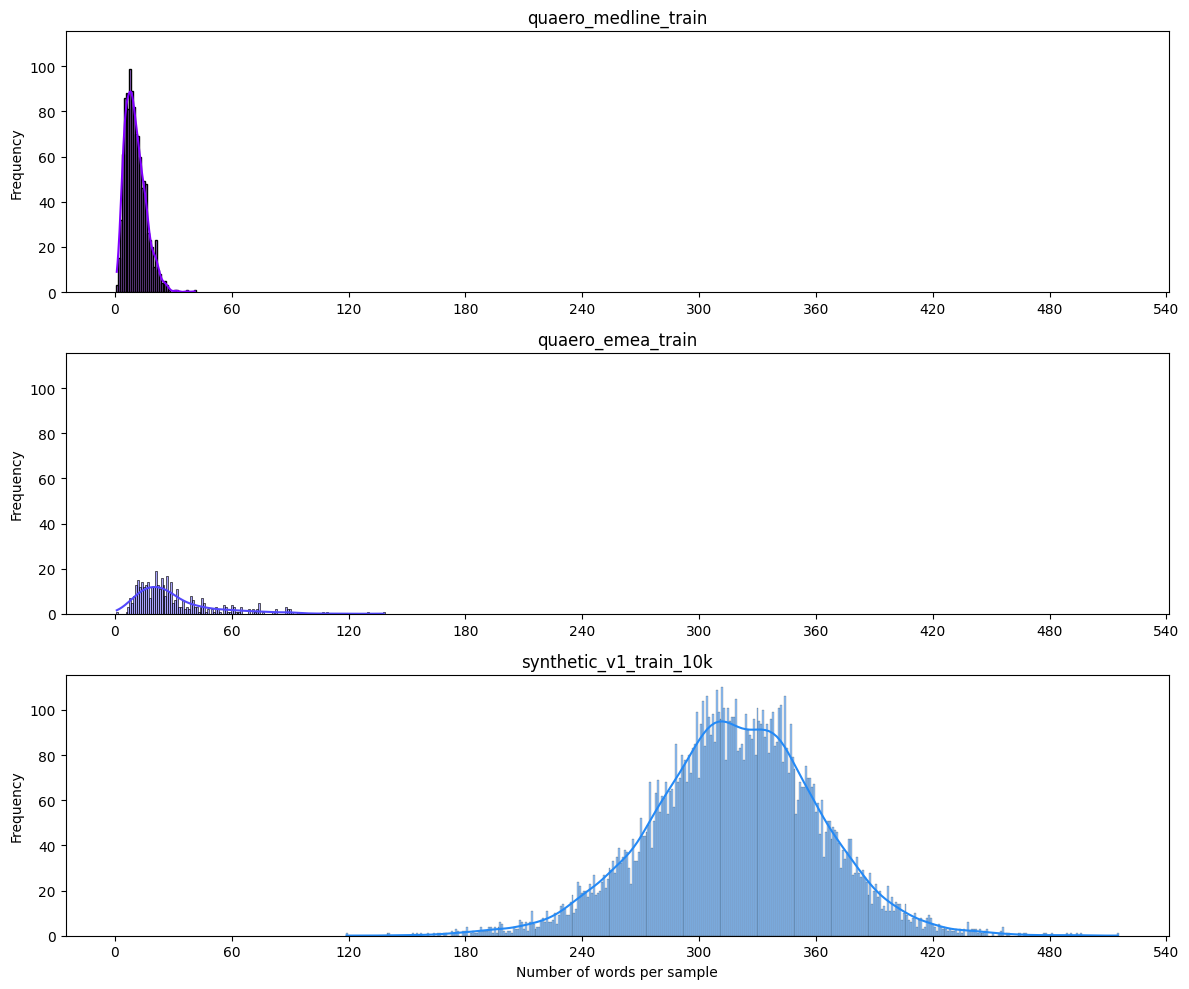

In [8]:
# plot num_words by sample

"""
plt.figure(figsize=(12, 6))

# sns.boxplot(x="group", y="num_words", data=combined_data, palette=colors)
sns.violinplot(x="group", y="num_words", data=combined_data, palette=colors)
# sns.histplot(hue="group", x="num_words", data=combined_data, palette=colors)

# plt.title("")
plt.xlabel("Data split")
plt.ylabel("Num of words per sample")
# plt.yscale('log')
plt.xticks(rotation=90)
plt.tight_layout()
"""

fig, axes = plt.subplots(num_groups, 1, figsize=(12, 10), sharex=True, sharey=True)

for idx, group in enumerate(groups):
    ax = axes[idx]
    sns.histplot(
        data=combined_data[combined_data["group"] == group],
        x="num_words",
        kde=True,
        color=colors[idx],
        ax=ax,
        discrete=True,
    )
    # title
    ax.set_title(group)
    ax.set_xlabel("Number of words per sample")
    ax.set_ylabel("Frequency")
    # ticks
    # ax.tick_params(axis="both", which="both", length=4, width=1, direction="out")
    ax.xaxis.set_tick_params(labelbottom=True)
    # ax.yaxis.set_tick_params(labelleft=True)
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    # ax.set_yscale('log')

# Adjust layout and display the plot
plt.tight_layout()

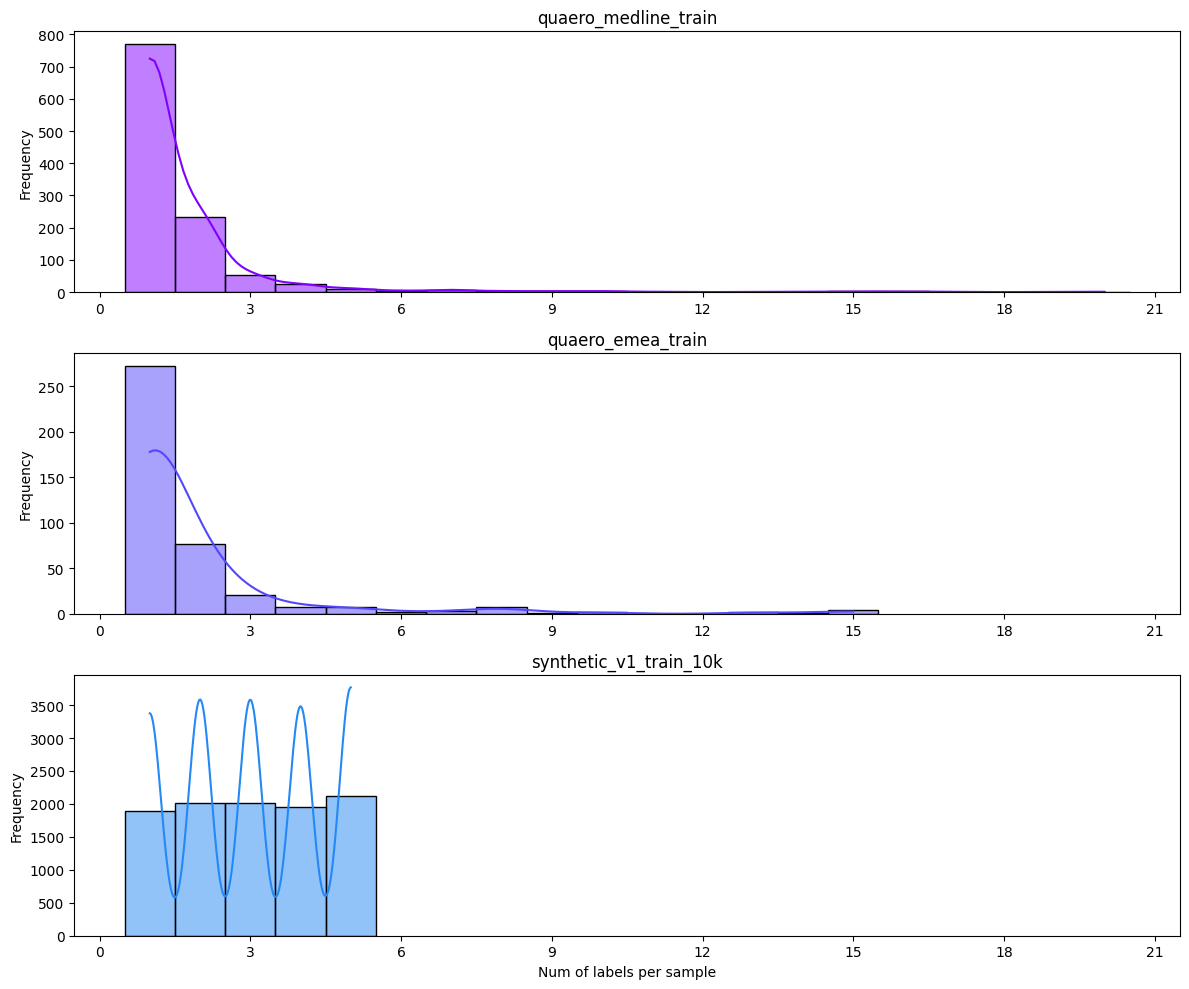

In [9]:
# plot num_labels by sample

"""
plt.figure(figsize=(12, 6))

# sns.boxplot(x='group', y='num_labels', data=combined_data, palette=colors)
sns.violinplot(x="group", y="num_labels", data=combined_data, palette=colors)

# plt.title("")
plt.xlabel("Data split")
plt.ylabel("Num of labels per sample")
# plt.yscale('log')
plt.xticks(rotation=90)
plt.tight_layout()
"""

# fig, axes = plt.subplots(num_groups, 1, figsize=(12, 10), sharex=True, sharey=True)
fig, axes = plt.subplots(num_groups, 1, figsize=(12, 10), sharex=True)

for idx, group in enumerate(groups):
    ax = axes[idx]
    sns.histplot(
        data=combined_data[combined_data["group"] == group],
        x="num_labels",
        kde=True,
        color=colors[idx],
        ax=ax,
        discrete=True,
    )
    # title
    ax.set_title(group)
    ax.set_xlabel("Num of labels per sample")
    ax.set_ylabel("Frequency")
    # ticks
    # ax.tick_params(axis="both", which="both", length=4, width=1, direction="out")
    ax.xaxis.set_tick_params(labelbottom=True)
    # ax.yaxis.set_tick_params(labelleft=True)
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    # ax.set_yscale('log')

# Adjust layout and display the plot
plt.tight_layout()

/tmp/ipykernel_4129945/753367074.py:63: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.lineplot(data=df, x="x", y="freq", hue="split", palette=colors)
/tmp/ipykernel_4129945/753367074.py:63: UserWarning: The palette list has more values (12) than needed (3), which may not be intended.
  sns.lineplot(data=df, x="x", y="freq", hue="split", palette=colors)


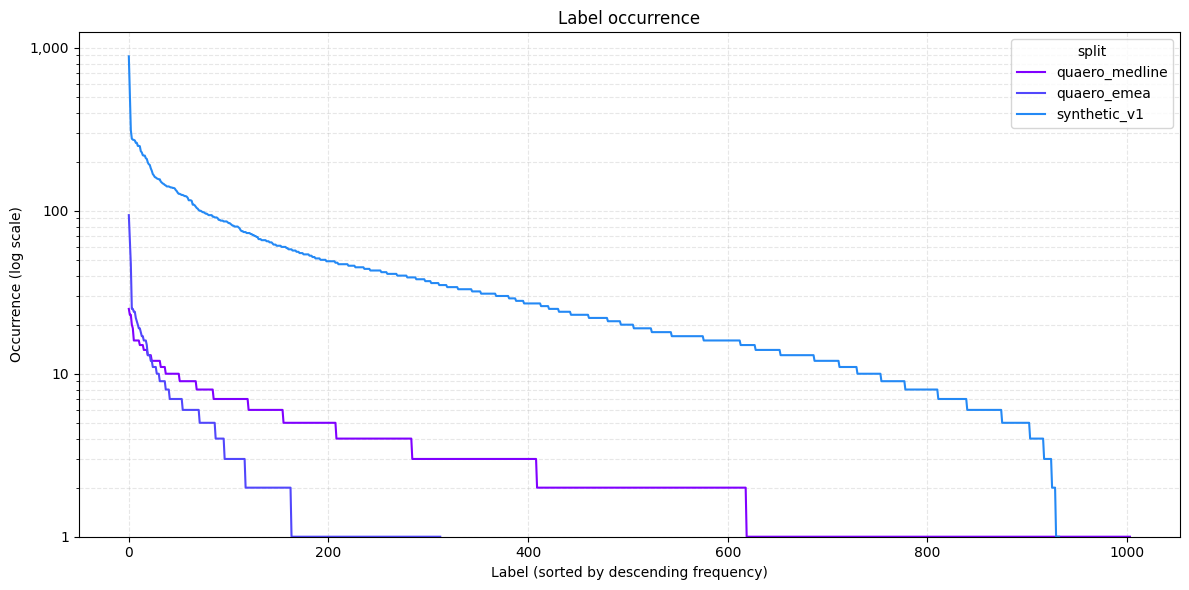

In [15]:
# plot num_labels by data split

"""
lc_df = pd.DataFrame({k: pd.Series(v) for k, v in label_counts_dict.items()})
# melt df to long format
lc_df_melted = lc_df.melt(var_name="split", value_name="label_counts")

plt.figure(figsize=(12, 6))
sns.violinplot(x="split", y="label_counts", data=lc_df_melted, palette=colors)

# plt.title("")
plt.xlabel("Data split")
plt.ylabel("Count of labels per dataset")
# plt.yscale("symlog")
# plt.ylim(0.1, 10)
plt.ylim(0.1, 100)
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(True, which="both", ls="--", alpha=0.3)
"""

# label_counts_dict_ = label_counts_dict
# label_counts_dict_ = {k: v for k, v in label_counts_dict.items() if "train" in k}
label_counts_dict_ = {k: v for k, v in label_counts_dict.items() if k in {"quaero_medline", "quaero_emea", "synthetic_v1"}}
# label_counts_dict_ = {k: v for k, v in label_counts_dict.items() if "sythetic_train" in k}

"""
# fig, axes = plt.subplots(len(label_counts_dict_), 1, figsize=(12, 10), sharex=True, sharey=True)
fig, axes = plt.subplots(len(label_counts_dict_), 1, figsize=(12, 10))

for idx, (group, label_counts) in enumerate(label_counts_dict_.items()):
    ax = axes[idx]
    sns.histplot(
        x=label_counts,
        kde=True,
        color=colors[idx],
        ax=ax,
        discrete=True,
    )
    # title
    ax.set_title(group)
    ax.set_xlabel("Number of labels per data split")
    ax.set_ylabel("Frequency")
    # ticks
    # ax.set_xlim(0, 30)
    # ax.tick_params(axis="both", which="both", length=4, width=1, direction="out")
    ax.xaxis.set_tick_params(labelbottom=True)
    # ax.yaxis.set_tick_params(labelleft=True)
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    # ax.set_yscale('log')

plt.tight_layout()
"""

data = []
for group, label_counts in label_counts_dict_.items():
    for i, c in enumerate(label_counts):
        data.append({"split": group, "x": i, "freq": c})

df = pd.DataFrame(data)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="x", y="freq", hue="split", palette=colors)

# plt.xlabel("Label index sorted by frequency")
# plt.ylabel("Frequency")
# plt.yscale('log')
# plt.tight_layout()
# plt.grid(True, which="both", ls="--", alpha=0.3)

plt.title("Label occurrence")
plt.xlabel("Label (sorted by descending frequency)")
plt.ylabel("Occurrence (log scale)")
plt.yscale("log")

# handle potential zero values
plt.ylim(bottom=max(1, df["freq"].min()))
# Customize y-axis ticks for better readability
plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda y, _: "{:,}".format(int(y)))
)

plt.tight_layout()
plt.grid(True, which="both", ls="--", alpha=0.3)

In [ ]:
# cooccurrence_ratios_dict_ = cooccurrence_ratios_dict
cooccurrence_ratios_dict_ = {
    k: v for k, v in cooccurrence_ratios_dict.items() if "train" in k
}
# cooccurrence_ratios_dict_ = {k: v for k, v in cooccurrence_ratios_dict.items() if "sythetic_train" in k}

fig, axes = plt.subplots(1, len(cooccurrence_ratios_dict_), figsize=(20, 6))

for idx, (group, cooccurrence_ratios) in enumerate(cooccurrence_ratios_dict_.items()):
    ax = axes[idx]
    # print(cooccurrence_ratios)
    sns.heatmap(
        cooccurrence_ratios,
        cmap="YlGnBu",
        xticklabels=100,
        yticklabels=100,
        square=False,
        ax=ax,
        cbar_kws={"label": "Value"},
    )  # , cbar_ax=ax[1,1]) #, vmax=np.max(M_1), center=np.max(M_1)/2.)
    ax.set_aspect("equal", adjustable="box")
    # title
    ax.set_title(group)
    ax.set_xlabel("Label ID")
    ax.set_ylabel("Label ID")
    # Improve tick labels
    # ax.set_xticks(ax.get_xticks()[::10])
    # ax.set_yticks(ax.get_yticks()[::10])

plt.tight_layout()

In [ ]:
# label coverage


def print_set_info(set_dict, name_a, name_b):
    print(f"{name_a}:", len(set_dict[name_a]))
    print(f"{name_b}:", len(set_dict[name_b]))
    # print(f"{name_b} & {name_a}:", len(set_dict[name_b] & set_dict[name_a]))
    print(
        f"{name_b} - {name_a}:",
        len(set_dict[name_b] - set_dict[name_a]),
        f"({len(set_dict[name_b] - set_dict[name_a]) / len(set_dict[name_b]) * 100:.2f}%)",
    )
    print()


# label coverage by subset
print_set_info(unique_labels_dict, "quaero_medline_train", "quaero_medline_valid")
print_set_info(unique_labels_dict, "quaero_medline_train", "quaero_medline_test")
print_set_info(unique_labels_dict, "quaero_emea_train", "quaero_emea_valid")
print_set_info(unique_labels_dict, "quaero_emea_train", "quaero_emea_test")

# overall coverage
# fmt: off
# unique_labels_dict["train"] = reduce(lambda x, y: x | y, [s for n, s in unique_labels_dict.items() if "train" in n])
# unique_labels_dict["valid"] = reduce(lambda x, y: x | y, [s for n, s in unique_labels_dict.items() if "valid" in n])
# unique_labels_dict["test"] = reduce(lambda x, y: x | y, [s for n, s in unique_labels_dict.items() if "test" in n])
print_set_info(unique_labels_dict, "train", "valid")
print_set_info(unique_labels_dict, "train", "test")
print_set_info(unique_labels_dict, "valid", "test")
# fmt: on